# Modeling with Feature Engineered Features

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from predict_test_data import predict_test_data
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import confusion_matrix
import itertools

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
train = pd.read_csv('../data/cleaned/train_final.csv')
test = pd.read_csv('../data/cleaned/test_final.csv')
wc_playoffs_train = pd.read_csv('../data/cleaned/wc_playoffs_final.csv')

To begin, let's just naively use all the features we have feature engineered.

In [3]:
columns = ['overall_diff', 'attack_away_defence_home_diff', 'attack_diff',
           'attack_home_defence_away_diff', 'defence_diff', 'midfield_diff',
           'prestige_diff', 'growth_diff', 'full_age_diff',
           'start_age_diff', 'value_euros_millions_diff',
           'wage_euros_thousands_diff', 'goalkeeper_overall_diff',
           'bup_dribbling_diff', 'bup_passing_diff', 'bup_speed_diff',
           'cc_crossing_diff', 'cc_passing_diff', 'cc_shooting_diff',
           'd_aggresion_diff', 'd_pressure_diff', 'd_width_diff', 
           'gdp_diff', 'is_home', 'raw_gdp_diff', 
           'win_momentum_past_1_games_diff', 'lose_momentum_past_1_games_diff',
           'win_momentum_past_2_games_diff', 'lose_momentum_past_2_games_diff',
           'win_momentum_past_3_games_diff', 'lose_momentum_past_3_games_diff',
           'win_momentum_past_4_games_diff', 'lose_momentum_past_4_games_diff',
           'win_momentum_past_5_games_diff', 'lose_momentum_past_5_games_diff',
]

train = train[columns + ['home_win']]
test = test[columns  + ['home_win', 'home_win_no_pk']]
wc_train = wc_playoffs_train[columns + ['home_win']]


In [4]:
#Same seed as baseline to ensure same train and validation sets so that comparisons are valid.
np.random.seed(14)
X_train, X_valid = train_test_split(train, test_size = 0.2)
y_train = X_train['home_win'].ravel()
X_train = X_train.drop(['home_win'], axis = 1)
y_valid= X_valid['home_win'].ravel()
X_valid = X_valid.drop(['home_win'], axis = 1)
y_test = test['home_win'].ravel()
y_test_no_pk = test['home_win_no_pk'].ravel()
X_test = test.drop(['home_win', 'home_win_no_pk'], axis = 1)
y_wc = wc_train['home_win'].ravel()
X_wc = wc_train.drop(['home_win'], axis = 1)

## Fitting the Models

Similar to before, we will fit different classification models on our data and select the one with the best validation accuracy. 

In [5]:
score = {}

In [6]:
lr_model = LogisticRegressionCV(solver = 'lbfgs', max_iter = 5000, cv = 5, multi_class='multinomial').fit(X_train, y_train)
score["Logistic Regression"] = {}
score["Logistic Regression"]["model"] = lr_model
score["Logistic Regression"]["Train Score"] = lr_model.score(X_train, y_train)
score["Logistic Regression"]["Validation Score"] = lr_model.score(X_valid, y_valid)

print("Logistic Regression Train Score: {}".format(score["Logistic Regression"]["Train Score"]))
print("Logistic Regression Validation Score: {}".format(score["Logistic Regression"]["Validation Score"]))

Logistic Regression Train Score: 0.5069215557020436
Logistic Regression Validation Score: 0.5368421052631579


Like before, we first check whether the variances across the three outcomes are equal, and they do seem quite equal.  

In [7]:
train.groupby('home_win').var()

,overall_diff,attack_away_defence_home_diff,attack_diff,attack_home_defence_away_diff,defence_diff,midfield_diff,prestige_diff,growth_diff,full_age_diff,start_age_diff,...,win_momentum_past_1_games_diff,lose_momentum_past_1_games_diff,win_momentum_past_2_games_diff,lose_momentum_past_2_games_diff,win_momentum_past_3_games_diff,lose_momentum_past_3_games_diff,win_momentum_past_4_games_diff,lose_momentum_past_4_games_diff,win_momentum_past_5_games_diff,lose_momentum_past_5_games_diff
home_win,,,,,,,,,,,,,,,,,,,,,
-1,31.393396,38.015113,40.858572,41.497639,37.554931,38.133908,25.423806,2.770866,2.489490,4.552043,...,0.294715,0.028413,0.582006,0.055080,0.838886,0.080313,1.163321,0.113674,1.431640,0.143578
0,36.158215,46.202150,47.654088,46.137393,43.559341,41.798216,30.781631,2.593080,2.596855,4.532752,...,0.271093,0.028312,0.523516,0.054950,0.808391,0.087430,1.049194,0.111427,1.315560,0.141014
1,37.105145,47.913430,49.295727,45.265228,43.509512,42.634416,26.985673,2.953428,2.406626,4.359358,...,0.248230,0.026205,0.465120,0.049671,0.717445,0.076786,1.023086,0.111290,1.291213,0.144669


In [8]:
lda_model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [9]:
score["LDA"] = {}
score["LDA"]["model"] = lda_model
score["LDA"]["Train Score"] = lda_model.score(X_train, y_train)
score["LDA"]["Validation Score"] = lda_model.score(X_valid, y_valid)
print("LDA Train Score: {}".format(score["LDA"]["Train Score"]))
print("LDA Validation Score: {}".format(score["LDA"]["Validation Score"]))

LDA Train Score: 0.5247198417930126
LDA Validation Score: 0.5473684210526316


Likewise, we try out QDA as well.

In [10]:
qda_model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)

In [11]:
score["QDA"] = {}
score["QDA"]['model'] = qda_model
score["QDA"]["Train Score"] = qda_model.score(X_train, y_train)
score["QDA"]["Validation Score"] = qda_model.score(X_valid, y_valid)
print("QDA Train Score: {}".format(score["QDA"]["Train Score"]))
print("QDA Validation Score: {}".format(score["QDA"]["Validation Score"]))

QDA Train Score: 0.4963744232036915
QDA Validation Score: 0.45263157894736844


We will also try out Random Forest.

In [12]:
rf_params = {'bootstrap': [True, False],
             'max_depth': [3, 5, 10, 20, 30, 40, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4, 10, 20],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [10, 50, 100, 200, 500]}

rf_model = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_params,\
                                   n_iter=50, scoring='accuracy', n_jobs=-1, cv=5, verbose=0).fit(X_train, y_train)


In [13]:
score["Random Forest"] = {}
score["Random Forest"]['model'] = rf_model
score["Random Forest"]["Train Score"] = rf_model.score(X_train, y_train)
score["Random Forest"]["Validation Score"] = rf_model.score(X_valid, y_valid)
print("Random Forest Train Score: {}".format(score["Random Forest"]["Train Score"]))
print("Random Forest Validation Score {}".format(score["Random Forest"]["Validation Score"]))

Random Forest Train Score: 0.5266974291364536
Random Forest Validation Score 0.5184210526315789


Finally, XGBoost.

In [14]:
xgb_params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
    }
xgb_model = RandomizedSearchCV(estimator=XGBClassifier(objective='multi:softmax', num_class = 3), param_distributions=xgb_params,\
                                   n_iter=50, scoring='accuracy', n_jobs=-1, cv=5, verbose=0).fit(X_train, y_train)

In [15]:
score["XGBoost"] = {}
score["XGBoost"]['model'] = xgb_model
score["XGBoost"]["Train Score"] = xgb_model.score(X_train, y_train)
score["XGBoost"]["Validation Score"] = xgb_model.score(X_valid, y_valid)
print("XGBoost Train Score: {}".format(score["XGBoost"]["Train Score"]))
print("XGBoost Validation Score {}".format(score["XGBoost"]["Validation Score"]))

XGBoost Train Score: 0.5398813447593935
XGBoost Validation Score 0.5342105263157895


In [16]:
df_result = pd.DataFrame(score).T
df_result

,Train Score,Validation Score,model
Logistic Regression,0.506922,0.536842,"LogisticRegressionCV(Cs=10, class_weight=None,..."
LDA,0.52472,0.547368,"LinearDiscriminantAnalysis(n_components=None, ..."
QDA,0.496374,0.452632,"QuadraticDiscriminantAnalysis(priors=None, reg..."
Random Forest,0.526697,0.518421,"RandomizedSearchCV(cv=5, error_score='raise-de..."
XGBoost,0.539881,0.534211,"RandomizedSearchCV(cv=5, error_score='raise-de..."


In [17]:
model_name = df_result['Validation Score'].astype(float).argmax()
print("We choose the final model to be the one with the highest validation score,\
 which is {} in this case".format(model_name))

We choose the final model to be the one with the highest validation score, which is LDA in this case


Now to predict the test set. Similar to before, we will use three different approaches. For the WC Playoff Model approach, we will still use logistic regression for now. 

In [18]:
wc_model = LogisticRegressionCV(solver = 'lbfgs', max_iter = 5000, cv = 5, multi_class='multinomial').fit(X_wc, y_wc)
test_pred = predict_test_data(X_test, df_result.loc[model_name].model)
test_pred_playoff = predict_test_data(X_test, df_result.loc[model_name].model, False, wc_model)
test_score = accuracy_score(y_test, test_pred)
test_score_playoff = accuracy_score(y_test, test_pred_playoff)
test_score_no_pk = df_result.loc[model_name].model.score(X_test, y_test_no_pk)
print("For the best Model, {}, the test accuracy is {} at 90 mins".format(model_name, test_score_no_pk))
print("For the best Model, {}, the test accuracy is {} at end (Softmax)".format(model_name, test_score))
print("For the best Model, {}, the test accuracy is {} at end (WC Playoff Model)".format(model_name, test_score_playoff))

final_models_score = {}
final_models_score[model_name] = {}
final_models_score[model_name]["Train Score"] = df_result.loc[model_name]['Train Score']
final_models_score[model_name]["Validation Score"] = df_result.loc[model_name]['Validation Score']
final_models_score[model_name]["Test Score (90 mins)"] = test_score_no_pk
final_models_score[model_name]["Test Score (Softmax)"] = test_score
final_models_score[model_name]["Test Score (WC Playoff Model)"] = test_score_playoff

For the best Model, LDA, the test accuracy is 0.640625 at 90 mins
For the best Model, LDA, the test accuracy is 0.671875 at end (Softmax)
For the best Model, LDA, the test accuracy is 0.65625 at end (WC Playoff Model)


Wow! It seems that our model with all the features is a decent improvement to the baseline model for the test set in all three approaches. However, the lower train and validation scores in general is a bit concerning. 

Like before, random forest seems to perform similarly to the best model, so we will utilize its feature importance again. 

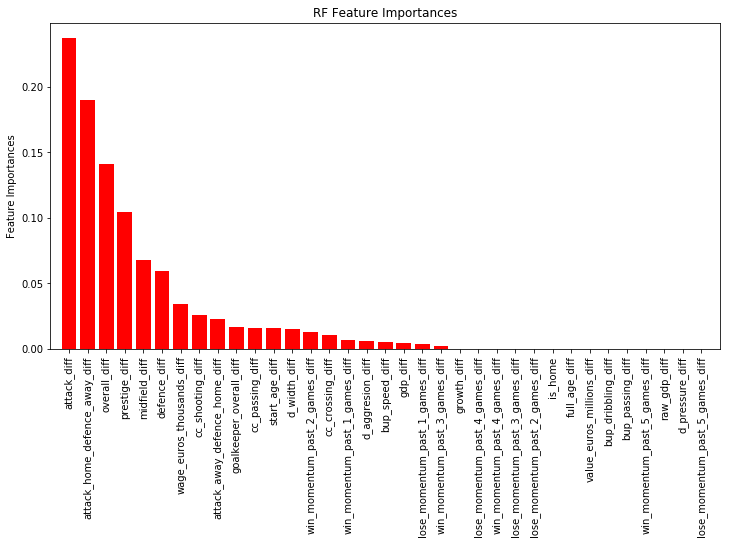

In [19]:
feature_importances = rf_model.best_estimator_.feature_importances_
plt.figure(figsize =(12, 6))
indices = np.argsort(feature_importances)[::-1]
plt.title("RF Feature Importances")
plt.bar(range(len(columns)), feature_importances[indices],
       color="r", align="center")
plt.xticks(range(len(columns)), np.array(columns)[indices], rotation = 90)
plt.ylabel('Feature Importances')
plt.xlim([-1, len(columns)]);

Like before, the ratings of the team are pretty important features. Many of the features we have engineered seem to be decent features as well, which should not be surprising from the EDA. Besides 3 of them, many of the momentum features are near the bottom, and this might be due to the fact that these momentum features are obviously highly correlated with each other, and this may be causing the lower train and validation scores. Many of the features in our feature are highly correlated; we would want to deal with this multicollinearity somehow to see if we can achieve better results. 

## Stacking

We saw that our models in general performed similarly in terms of train/validation. Why not try stacking the models together? We will stack the logistic regression, LDA, QDA, Random Forest, and XGBoost models.

In [20]:
def fit_stack_model(models, X_train, y_train): 
    predictions = []
    for model in models:
        predictions.append(model.predict(X_train))
        
    predictions = np.array(predictions).T
    logit = LogisticRegression(C=1000).fit(predictions, y_train)
    return logit
    
def stack_model_predict(models, stack_model, X, test = False):
    predictions = []
    for model in models:
        predictions.append(model.predict(X))        
    predictions = np.array(predictions).T
    if not test:
        return stack_model.predict(predictions)
    else:
        return stack_model.predict_proba(predictions)

In [21]:
models = df_result['model']
stack_model = fit_stack_model(models, X_train, y_train)
print("Stacking Model Train Score: {}".format(accuracy_score(y_train, stack_model_predict(models, stack_model,
                                                                                         X_train))))
print("Stacking Model Validation Score: {}".format(accuracy_score(y_valid, stack_model_predict(models, stack_model,
                                                                                         X_valid))))

Stacking Model Train Score: 0.5346077785102176
Stacking Model Validation Score: 0.5342105263157895


In [22]:
stack_model_test_pred_prob = stack_model_predict(models, stack_model, X_test, True)
stack_model_test_pred = [np.where(np.argsort(val) == 1)[0][0]-1 if (i >= 48) & (np.argmax(val) == 1)
                       else np.argmax(val)-1 for i, val in enumerate(stack_model_test_pred_prob)]
stack_model_test_pred_wc_model = [np.argmax(val) - 1 for val in stack_model_test_pred_prob[:48]] +\
                                list(wc_model.predict(X_test[48:]))
                                    

stack_model_test_acc = accuracy_score(y_test, stack_model_test_pred)
stack_model_test_acc_no_pk = accuracy_score(y_test_no_pk, stack_model_predict(models, stack_model, X_test))
stack_model_test_acc_wc_model = accuracy_score(y_test, stack_model_test_pred_wc_model)


print("Stacking Model Test Score at 90 mins: {}".format(stack_model_test_acc_no_pk))
print("Stacking Model Test Score at end (Softmax): {}".format(stack_model_test_acc))
print("Stacking Model Test Score at end (WC Playoff Model): {}".format(stack_model_test_acc_wc_model))

final_models_score["Stacking"] = {}
final_models_score["Stacking"]["Train Score"] = accuracy_score(y_train, stack_model_predict(models, stack_model,
                                                                                         X_train))
final_models_score["Stacking"]["Validation Score"] = accuracy_score(y_valid, stack_model_predict(models, stack_model,
                                                                                         X_valid))
final_models_score["Stacking"]["Test Score (90 mins)"] = stack_model_test_acc_no_pk
final_models_score["Stacking"]["Test Score (Softmax)"] = stack_model_test_acc
final_models_score["Stacking"]["Test Score (WC Playoff Model)"] = stack_model_test_acc_wc_model


Stacking Model Test Score at 90 mins: 0.625
Stacking Model Test Score at end (Softmax): 0.65625
Stacking Model Test Score at end (WC Playoff Model): 0.65625


It seems that stacking in this case did not really help that much. The test accuarcies are quite low, although still higher than those of the baseline model.

As mentioned before, we are a bit concerned about the fact that our features are highly correlated, which potentially affects our predictions. 

## Principal Component Regression

Principal Component Analysis (PCA) is a way to reduce the dimensionality of dataset by summarizing the variation in our data into a set of new predictors called principal components. These principal components are linear combinations of our original predictors. By selecting the top few principal components, we are projecting our dataset into the space defined by these components. This means that we are projecting our dataset onto a space of smaller dimensionality. Importantly, this will help us reduce the multicollinearity that might be affecting our predictions. Each principal component is constructed such that they are orthogonal with each other. Nonetheless, we understand that this will limit the interpretability of our coefficients.

Principal Component Regression (PCR) is basically using the new predictors of reduced dimensionality in a regression problem. In this problem, we inputed the new principal components into our standard logistic regression. In order to decide the number of principal components to keep, we cross-validated the number of principal components that gives us the best validation accuracy. 

In [23]:
# scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_wc_scaled = scaler.transform(X_wc)

# PCA on data
pca = PCA().fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)

In [24]:
pcr_train_score = []
pcr_valid_score = []
pcr_wc_score = []

for i in np.arange(1, X_train.shape[1]):
    pca_cv = PCA(n_components=i).fit(X_train_scaled)
    X_train_pca_cv = pca_cv.transform(X_train_scaled)
    X_valid_pca_cv = pca_cv.transform(X_valid_scaled)
    X_test_pca_cv = pca_cv.transform(X_test_scaled)
    X_wc_pca = pca_cv.transform(X_wc_scaled)
    pcr_cv_mod = LogisticRegressionCV(solver = 'lbfgs', 
                                      max_iter = 5000, 
                                      cv = 5, 
                                      multi_class='multinomial').fit(X_train_pca_cv, y_train)
    pcr_train_score.append(pcr_cv_mod.score(X_train_pca_cv, y_train))
    pcr_valid_score.append(pcr_cv_mod.score(X_valid_pca_cv, y_valid))
    
    #X_wc has very few samples
    if i < X_wc.shape[0]:
        pcr_wc_mod = LogisticRegressionCV(solver = 'lbfgs', 
                                          max_iter = 5000, 
                                          cv = 5, 
                                          multi_class='multinomial').fit(X_wc_pca, y_wc)
        pcr_wc_score.append(pcr_wc_mod.score(X_wc_pca, y_wc))

In [25]:
X_wc_pca.shape[1]

34

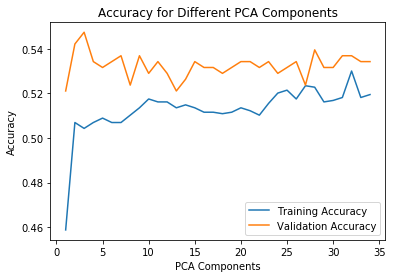

In [26]:
plt.plot(np.arange(1,len(pcr_train_score)+1), pcr_train_score, label='Training Accuracy')
plt.plot(np.arange(1,len(pcr_valid_score)+1), pcr_valid_score, label='Validation Accuracy')


plt.title('Accuracy for Different PCA Components')
plt.xlabel('PCA Components')
plt.ylabel('Accuracy')
plt.legend();

In [27]:
pca_best_com = np.argmax(pcr_valid_score)+1
print('Best Validation Accuracy Number of Components: {}'.format(pca_best_com))

Best Validation Accuracy Number of Components: 3


In [28]:
# best mod with highest validation accuracy
pca_best = PCA(n_components=pca_best_com).fit(X_train_scaled)
X_train_pca_best = pca_best.transform(X_train_scaled)
X_valid_pca_best = pca_best.transform(X_valid_scaled)

X_wc_pca_best = pca_best.transform(X_wc_scaled)


# fit models
pcr_best_mod = LogisticRegressionCV(solver = 'lbfgs', 
                                    max_iter = 5000, 
                                    cv = 5, 
                                    multi_class='multinomial').fit(X_train_pca_best, y_train)



In [29]:
# Best Validation Accuracy
score["pcr_best"] = {}
score["pcr_best"]["model"] = pcr_best_mod
score["pcr_best"]["Train Score"] = pcr_best_mod.score(X_train_pca_best, y_train)
score["pcr_best"]["Validation Score"] = pcr_best_mod.score(X_valid_pca_best, y_valid)
print("PCR (Best) Train Score: {}".format(score["pcr_best"]["Train Score"]))
print("PCR (Best) Validation Score: {}".format(score["pcr_best"]["Validation Score"]))


PCR (Best) Train Score: 0.5042847725774555
PCR (Best) Validation Score: 0.5473684210526316


In [30]:
# test set
# For third approach, find number of components that maximize the training score of the WC Playoff model.
pca_best_com_wc = np.argmax(pcr_wc_score)+1
pca_best_wc = PCA(n_components=pca_best_com_wc).fit(X_wc_scaled)
X_wc_pca_best = pca_best_wc.transform(X_wc_scaled)

pca_wc_mod = LogisticRegressionCV(solver = 'lbfgs', 
                                    max_iter = 5000, 
                                    cv = 5, 
                                    multi_class='multinomial').fit(X_wc_pca_best, y_wc)
X_test_pca_best = pca_best.transform(X_test_scaled)
X_test_pca_best_wc = pca_best_wc.transform(X_test_scaled)
pcr_best_test_pred = predict_test_data(X_test_pca_best, pcr_best_mod)
pcr_best_test_pred_wc_model = list(pcr_best_mod.predict(X_test_pca_best[:48])) + list(pca_wc_mod.predict(X_test_pca_best_wc[48:]))
pcr_best_test_acc = accuracy_score(y_test, pcr_best_test_pred)
pcr_best_test_acc_no_pk = pcr_best_mod.score(X_test_pca_best, y_test_no_pk)
pcr_best_test_acc_wc_model = accuracy_score(y_test, pcr_best_test_pred_wc_model)

print("PCR (Best) Test Score at 90 mins: {}".format(pcr_best_test_acc_no_pk))
print("PCR (Best) Test Score at end (Softmax): {}".format(pcr_best_test_acc))
print("PCR (Best) Test Score at end (WC Playoffs Model): {}".format(pcr_best_test_acc_wc_model))


final_models_score["PCR"] = {}
final_models_score["PCR"]["Train Score"] = score['pcr_best']['Train Score']
final_models_score["PCR"]["Validation Score"] = score['pcr_best']['Validation Score']
final_models_score["PCR"]["Test Score (90 mins)"] = pcr_best_test_acc_no_pk
final_models_score["PCR"]["Test Score (Softmax)"] = pcr_best_test_acc
final_models_score["PCR"]["Test Score (WC Playoff Model)"] = pcr_best_test_acc_wc_model

PCR (Best) Test Score at 90 mins: 0.5625
PCR (Best) Test Score at end (Softmax): 0.578125
PCR (Best) Test Score at end (WC Playoffs Model): 0.609375


In this case, PCR was not a good option. The test accuracy decreased quite significantly. We may need to take into the account the outcome as well when we reduce the dimension of our feature set.

## Partial Least Squares Regression

Another way that can help us deal with the issues of multicollinearity in our dataset is Partial Least Squares Regression (PLSR). Similar to PCA, PLSR involves projecting the predictors onto orthogonal components. However, the PLSR components are constructed such that they not only approximate the predictors, but are also well correlated with the response. As such, we assume that both the predictors and the response are functions of (reduced) principal components. In this problem, our response variable is a multi-class categorical variable. As such, we could use the PLS2 algorithm which simultaneously decomposes on the multi-class variable directly. We could also use the PLS1 algorithm on each category in our response variable separately. 

To demonstrate how the Partial Least Squares algorithms works, we have included a pseudo-code for PLS1:

Set $X_0 = X$, and $y_0 = y$

for $h = 1, 2, ... r$ do (where r is the dimension of the predictors)

$\hspace{1cm} \mathbf{w_h} = \mathbf{X^T_{h-1}y_{h-1}/y^T_{h-1}y_{h-1}}$ (regress predictors $x_j$ on response $y$)

$\hspace{1cm} ||\mathbf{w_h}|| = 1$ (normalize)

$\hspace{1cm} \mathbf{z_h} = \mathbf{X_{h-1}w_h/w^T_hw_h}$ (regress predictors $x_j$ on weights $w_h$)

$\hspace{1cm} \mathbf{p_h} = \mathbf{X^T_{h-1}z_h/z^T_hz_h}$ (regress predictors $x_j$ on components $z_h$)

$\hspace{1cm} \mathbf{X_h} = \mathbf{X_{h-1} - z_hp^T_h}$ (deflate $X_{h-1}$)

$\hspace{1cm} d_h = \mathbf{y^T_hz_h/z^T_hz_h}$ (regress response $y_h$ onto components $z_h$)

$\hspace{1cm} \mathbf{y_h} = \mathbf{y_{h-1} - d_hz_h}$ (deflate $y_{h-1}$)

end for

The PLS2 algorithm is just an extension for a multi-dimensional response variable.

Importantly, PLS selects components which gives us the greatest reduction in the covariance of our predictors and response. If we represent our components as $\mathbf{z}$, and the response as $\mathbf{y}$, it can be shown that PLSR optimizes with respect to the weights $\mathbf{w}$

$$ \arg\max_{\mathbf{w}} cor^2(\mathbf{y, z})var(\mathbf{y})var(\mathbf{z})$$

It can thus be seen that PLSR tries to maximize the correlation between the components and the response whilst trying to maximize the variance captured by the components. 

This not only allows us to resolve the multicollinearity issues through the creation of orthogonal components just as in PCR, but also allows us to create components that are correlated with the response. It is likely that this might perform even better than PCR.

In [31]:
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_valid_lb = lb.fit_transform(y_valid)
y_wc_lb = lb.fit_transform(y_wc)

In [32]:
plsda1_train_score = []
plsda1_valid_score = []


# PLS1
for i in np.arange(1, X_train.shape[1]):
    # initialize empty array
    train_pred = np.empty(y_train_lb.shape)
    valid_pred = np.empty(y_valid_lb.shape)
    
    plsda1_mod = PLSRegression(n_components=i, scale=False) 
    plsda1_mod.fit(X_train_scaled, y_train_lb[:,0])
    train_pred[:,0] = plsda1_mod.predict(X_train_scaled).ravel()
    valid_pred[:,0] = plsda1_mod.predict(X_valid_scaled).ravel()
    plsda1_mod.fit(X_train_scaled, y_train_lb[:,1])
    train_pred[:,1] = plsda1_mod.predict(X_train_scaled).ravel()
    valid_pred[:,1] = plsda1_mod.predict(X_valid_scaled).ravel()
    plsda1_mod.fit(X_train_scaled, y_train_lb[:,2])
    train_pred[:,2] = plsda1_mod.predict(X_train_scaled).ravel()
    valid_pred[:,2] = plsda1_mod.predict(X_valid_scaled).ravel()

    
    plsda1_train_score.append(accuracy_score(y_train, np.argmax(train_pred, axis=1) - 1))
    plsda1_valid_score.append(accuracy_score(y_valid, np.argmax(valid_pred, axis=1) - 1))

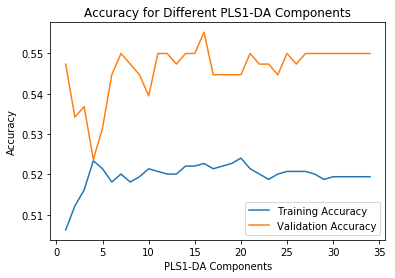

In [33]:
plt.plot(np.arange(1,len(plsda1_train_score)+1), plsda1_train_score, label='Training Accuracy')
plt.plot(np.arange(1,len(plsda1_valid_score)+1), plsda1_valid_score, label='Validation Accuracy')

plt.title('Accuracy for Different PLS1-DA Components')
plt.xlabel('PLS1-DA Components')
plt.ylabel('Accuracy')
plt.legend();

In [34]:
plsda1_best_com = np.argmax(plsda1_valid_score)+1
print('Best Validation Accuracy Number of Components: {}'.format(plsda1_best_com))

Best Validation Accuracy Number of Components: 16


In [35]:
# check test accuracy
# initialize arrays
best_train_pred = np.empty(y_train_lb.shape)
best_valid_pred = np.empty(y_valid_lb.shape)
best_test_pred = np.empty((y_test.shape[0],3))

# fit model
plsda1_best_mod = PLSRegression(n_components=plsda1_best_com, scale=False) 

# predict
plsda1_best_mod.fit(X_train_scaled, y_train_lb[:,0])
best_train_pred[:,0] = plsda1_best_mod.predict(X_train_scaled).ravel()
best_valid_pred[:,0] = plsda1_best_mod.predict(X_valid_scaled).ravel()
best_test_pred[:,0] = plsda1_best_mod.predict(X_test_scaled).ravel()

# predict
plsda1_best_mod.fit(X_train_scaled, y_train_lb[:,1])
best_train_pred[:,1] = plsda1_best_mod.predict(X_train_scaled).ravel()
best_valid_pred[:,1] = plsda1_best_mod.predict(X_valid_scaled).ravel()
best_test_pred[:,1] = plsda1_best_mod.predict(X_test_scaled).ravel()

# predict
plsda1_best_mod.fit(X_train_scaled, y_train_lb[:,2])
best_train_pred[:,2] = plsda1_best_mod.predict(X_train_scaled).ravel()
best_valid_pred[:,2] = plsda1_best_mod.predict(X_valid_scaled).ravel()
best_test_pred[:,2] = plsda1_best_mod.predict(X_test_scaled).ravel()




In [36]:
# Best Validation Accuracy
score["plsda1_best"] = {}
score["plsda1_best"]["model"] = plsda1_best_mod
score["plsda1_best"]["Train Score"] = accuracy_score(y_train, np.argmax(best_train_pred, axis=1) - 1)
score["plsda1_best"]["Validation Score"] = accuracy_score(y_valid, np.argmax(best_valid_pred, axis=1) - 1)
print("PLS1-DA (Best) Train Score: {}".format(score["plsda1_best"]["Train Score"]))
print("PLS1-DA (Best) Validation Score: {}".format(score["plsda1_best"]["Validation Score"]))

PLS1-DA (Best) Train Score: 0.5227422544495716
PLS1-DA (Best) Validation Score: 0.5552631578947368


In [37]:
plsda2_train_score = []
plsda2_valid_score = []
plsda_wc_score = []

# PLS2
for i in np.arange(1, X_train.shape[1]):
    plsda2_mod = PLSRegression(n_components=i, scale=False) 
    plsda2_mod.fit(X_train_scaled, y_train_lb)

    plsda2_train_score.append(accuracy_score(y_train, np.argmax(plsda2_mod.predict(X_train_scaled), axis=1) - 1))
    plsda2_valid_score.append(accuracy_score(y_valid, np.argmax(plsda2_mod.predict(X_valid_scaled), axis=1) - 1))
    
    if i < X_wc.shape[0]:
        #When there are only two labels, >0 means class 1 have higher probability
        plsda_mod_wc = PLSRegression(n_components=i, scale=False) 
        plsda_mod_wc.fit(X_wc_scaled, y_wc_lb)
        plsda_wc_score.append(accuracy_score(y_wc, list(np.where(plsda_mod_wc.predict(X_wc_scaled) > 0, 1, -1))))

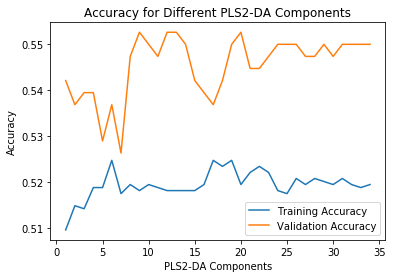

In [38]:
plt.plot(np.arange(1,len(plsda2_train_score)+1), plsda2_train_score, label='Training Accuracy')
plt.plot(np.arange(1,len(plsda2_valid_score)+1), plsda2_valid_score, label='Validation Accuracy')

plt.title('Accuracy for Different PLS2-DA Components')
plt.xlabel('PLS2-DA Components')
plt.ylabel('Accuracy')
plt.legend();

In [39]:
plsda2_best_com = np.argmax(plsda2_valid_score)+1
print('Best Validation Accuracy Number of Components: {}'.format(plsda2_best_com))

Best Validation Accuracy Number of Components: 9


In [40]:
plsda2_best_mod = PLSRegression(n_components=plsda2_best_com, scale=False) 
plsda2_best_mod.fit(X_train_scaled, y_train_lb);

In [41]:
# Best Validation Accuracy
score["plsda2_best"] = {}
score["plsda2_best"]["model"] = plsda2_best_mod
score["plsda2_best"]["Train Score"] = accuracy_score(y_train, np.argmax(plsda2_best_mod.predict(X_train_scaled), axis=1) - 1)
score["plsda2_best"]["Validation Score"] = accuracy_score(y_valid, np.argmax(plsda2_best_mod.predict(X_valid_scaled), axis=1) - 1)
print("PLS2-DA (Best) Train Score: {}".format(score["plsda2_best"]["Train Score"]))
print("PLS2-DA (Best) Validation Score: {}".format(score["plsda2_best"]["Validation Score"]))

PLS2-DA (Best) Train Score: 0.5181278839815425
PLS2-DA (Best) Validation Score: 0.5526315789473685


In the case of binary labels, PLS1-DA and PLS2-DA are the same, so we will look at the third approach in PLS2-DA.

In [42]:


plsda2_best_com_wc = np.argmax(plsda_wc_score)+1


plsda2_wc_mod = PLSRegression(n_components=plsda2_best_com_wc, scale=False).fit(X_wc_scaled, y_wc_lb)

plsda2_best_test_pred = [np.where(np.argsort(val) == 1)[0][0]-1 if (i >= 48) & (np.argmax(val) == 1)
                       else np.argmax(val)-1 for i, val in enumerate(plsda2_best_mod.predict(X_test_scaled))]

plsda2_best_test_pred_wc = [np.argmax(val)-1 for val in plsda2_best_mod.predict(X_test_scaled[:48])] +\
                        list(np.where(plsda2_wc_mod.predict(X_test_scaled[48:]) > 0, 1, -1))

plsda1_best_test_pred = [np.where(np.argsort(val) == 1)[0][0]-1 if (i >= 48) & (np.argmax(val) == 1) 
                       else np.argmax(val)-1 for i, val in enumerate(best_test_pred)]

print("PLS1-DA (Best) Test Score at 90 mins: {}".format(accuracy_score(y_test_no_pk, np.argmax(best_test_pred, axis=1) - 1)))
print("PLS1-DA (Best) Test Score at end (Softmax): {}".format(accuracy_score(y_test, plsda1_best_test_pred)))

print("PLS2-DA (Best) Test Score at 90 mins: {}".format(accuracy_score(y_test_no_pk, np.argmax(plsda2_best_mod.predict(X_test_scaled), axis=1) - 1)))
print("PLS2-DA (Best) Test Score at end (Softmax): {}".format(accuracy_score(y_test, plsda2_best_test_pred)))
print("PLS1-DA/PLS2-DA (Best) Test Score at end (WC Playoffs Model): {}".format(accuracy_score(y_test, plsda2_best_test_pred_wc)))

final_models_score["PLS1-DA"] = {}
final_models_score["PLS1-DA"]["Train Score"] = score['plsda1_best']['Train Score']
final_models_score["PLS1-DA"]["Validation Score"] = score['plsda1_best']['Validation Score']
final_models_score["PLS1-DA"]["Test Score (90 mins)"] = accuracy_score(y_test_no_pk, np.argmax(best_test_pred, axis=1) - 1)
final_models_score["PLS1-DA"]["Test Score (Softmax)"] = accuracy_score(y_test, plsda1_best_test_pred)
#Same as PLS2-DA as mentioned
final_models_score["PLS1-DA"]["Test Score (WC Playoff Model)"] = accuracy_score(y_test, plsda2_best_test_pred_wc)

final_models_score["PLS2-DA"] = {}
final_models_score["PLS2-DA"]["Train Score"] = score['plsda2_best']['Train Score']
final_models_score["PLS2-DA"]["Validation Score"] = score['plsda2_best']['Validation Score']
final_models_score["PLS2-DA"]["Test Score (90 mins)"] = accuracy_score(y_test_no_pk, np.argmax(plsda2_best_mod.predict(X_test_scaled), axis=1) - 1)
final_models_score["PLS2-DA"]["Test Score (Softmax)"] = accuracy_score(y_test, plsda2_best_test_pred)
final_models_score["PLS2-DA"]["Test Score (WC Playoff Model)"] = accuracy_score(y_test, plsda2_best_test_pred_wc)



PLS1-DA (Best) Test Score at 90 mins: 0.640625
PLS1-DA (Best) Test Score at end (Softmax): 0.6875
PLS2-DA (Best) Test Score at 90 mins: 0.59375
PLS2-DA (Best) Test Score at end (Softmax): 0.625
PLS1-DA/PLS2-DA (Best) Test Score at end (WC Playoffs Model): 0.65625


Compared to the full model,  we do not see much change in the PLS1-DA model on the test set while we see a decrease in performance of PLS2-DA on the test set, although PLS1-DA does perform better in the second approach than the full model does; thus PLS1-DA is the best model we have seen so far! What's more important is that the validation scores for PLS1-DA were higher than those in the full model. It is likely that multicollinearity was causing the decrease in our validation scores.

Now, suppose we don't actually know anything about the test set. Which model would we have actually chosen? Like before, we can only look at the validation scores. 

In [43]:
final_df_result = pd.DataFrame(final_models_score).T
final_df_result = final_df_result[['Train Score', 'Validation Score', 'Test Score (90 mins)', 'Test Score (Softmax)',
                                  'Test Score (WC Playoff Model)']]
final_df_result

,Train Score,Validation Score,Test Score (90 mins),Test Score (Softmax),Test Score (WC Playoff Model)
LDA,0.524720,0.547368,0.640625,0.671875,0.656250
Stacking,0.534608,0.534211,0.625000,0.656250,0.656250
PCR,0.504285,0.547368,0.562500,0.578125,0.609375
PLS1-DA,0.522742,0.555263,0.640625,0.687500,0.656250
PLS2-DA,0.518128,0.552632,0.593750,0.625000,0.656250


Based on validation scores, we would have chosen PLS1-DA, the best model!

In [ ]:
#Combine with baseline model results and save to csv
baseline_results = pd.read_csv('baseline_model_results.csv')
final_df_result['Model Name'] = final_df_result.index
all_model_results = baseline_results.append(final_df_result.reset_index(drop = True)).reset_index(drop = True)
all_model_results = all_model_results[['Model Name', 'Train Score', 'Validation Score', 'Test Score (90 mins)', 'Test Score (Softmax)',
                                  'Test Score (WC Playoff Model)']]
all_model_results.to_csv('all_model_results.csv', index = False)

Let's see the confusion matrices for our best model, PLS1-DA.

In [45]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


In [46]:
np.set_printoptions(precision=2)


train_cm = confusion_matrix(y_train, np.argmax(best_train_pred, axis=1) - 1)
test_90mins_cm =  confusion_matrix(y_test_no_pk, np.argmax(best_test_pred, axis=1) - 1)
test_cm = confusion_matrix(y_test, plsda1_best_test_pred)
test_wc_cm =  confusion_matrix(y_test, plsda2_best_test_pred_wc)

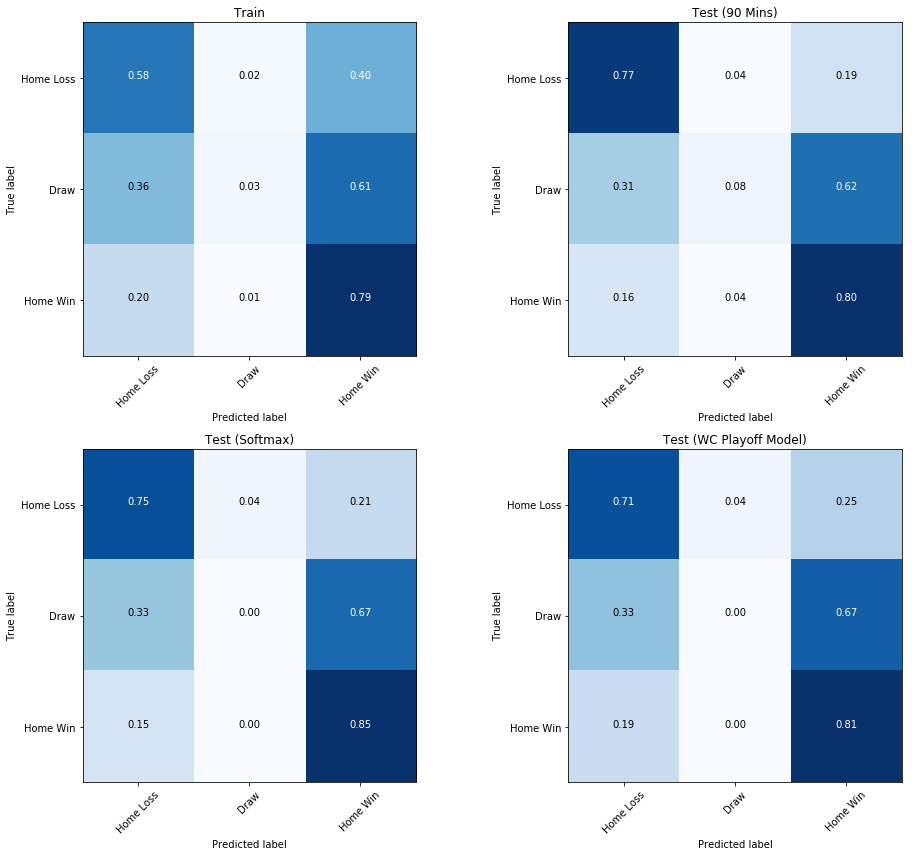

In [47]:
fig, axs = plt.subplots(2, 2, figsize = (14, 12))
plot_confusion_matrix(train_cm, ['Home Loss', 'Draw', 'Home Win'], axs[0,0], True, 'Train')
plot_confusion_matrix(test_90mins_cm, ['Home Loss', 'Draw', 'Home Win'], axs[0,1], True, 'Test (90 Mins)')
plot_confusion_matrix(test_cm, ['Home Loss', 'Draw', 'Home Win'], axs[1,0], True, 'Test (Softmax)')
plot_confusion_matrix(test_wc_cm, ['Home Loss', 'Draw', 'Home Win'], axs[1,1], True, 'Test (WC Playoff Model)')
plt.tight_layout()

The model is actually predicting some draws now for the training set and test set, although still very little. As mentioned before, it is just very hard to predict draws, but this is definitely an improvement compared to the baseline model. 

Compared to the baseline model, it seems that the model is better in predicting when "home" team loses in the test set in all three approaches. This might be due to some bias of how we feature engineer. Since none of us really were experts in soccer, we chose features that we observed from the World Cup alone, so these features might be biased toward the test set. 

The Softmax approach had higher home loss and home win accuracies than the WC Playoff Model approach; this might be due to the small training set for the playoff matches, so we could just be overfitting to the traing set. As mentioned in the baseline model, we cannot really compare the confusion matrices of the three approaches to the test set, as the true labels between the 90 minutes approach are different from those than the true labels in the other two approaches. 